In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
# cdist: compute distance between collections of inputs
from scipy.spatial.distance import cdist

# Load the raw data

In [2]:
df_house_sales = pd.read_csv('data/eda_king_county_house_sales_cleaned.csv')
df_house_details = pd.read_csv('data/eda_king_county_house_details_cleaned.csv')

# Clenaup house sales
- drop id column, rows are unique via house_id and date
- date to datetime

In [3]:
df_house_sales.drop(columns=['id'], inplace=True)
df_house_sales['date'] = pd.to_datetime(df_house_sales['date'])

# Cleanup house details
- fillna for waterfront, view, year renovated and basement, all with 0
- 0 seems to be the mode for view but maybe a probability based on the lat/long would be better
- year renovated 0. values could also be set to built year

In [4]:
df_house_details['waterfront'].fillna(0, inplace=True)
df_house_details['view'].fillna(0, inplace=True)
df_house_details['sqft_basement'].fillna(0, inplace=True)
# The lambda function here is used to apply a custom transformation to each value in the 'yr_renovated' column after filling NaN with 0.
# Specifically, it multiplies the year by 0.1 if it is greater than 0 (suggesting the house was renovated), and keeps it 0 otherwise.
# This kind of logic could be for normalization or to encode 'yr_renovated' as a feature with reduced scale.
df_house_details['yr_renovated'] = df_house_details['yr_renovated'].fillna(0).apply(
    lambda x: x * 0.1 if x > 0 else 0
)
df_house_details = df_house_details.rename({'id': 'house_id'}, axis=1)

# Add the price per sqft (living, most relevant) to sales dataframe

In [5]:

df_house_sales = pd.merge(df_house_sales, df_house_details[['house_id', 'sqft_living']], on='house_id')
#df_house_sales.head()
df_house_sales = df_house_sales.eval('price_p_sqft_lv = `price` / `sqft_living`')
df_house_sales = df_house_sales.drop('sqft_living', axis=1)

# Add a column approximating population density per house

In [6]:
# Calculate pairwise distances between all houses
# Here, we calculate pairwise distances between all houses based on their latitude and longitude.
# The cdist function from scipy is used with the 'euclidean' metric,
# which assumes that 'lat' and 'long' can be treated as x/y Cartesian coordinates.
# Note: This Euclidean approximation works reasonably well for small geographic regions (like a single county),
# but it is not as accurate as using a haversine or great-circle distance for locations far apart or global scales.
coords = df_house_details[['lat', 'long']].values
distances = cdist(coords, coords, metric='euclidean')

# Avoid division by zero by setting diagonal to infinity
np.fill_diagonal(distances, np.inf)

# Replace zero distances with a small value to avoid division by zero
distances[distances == 0] = np.min(distances[distances > 0])

# Calculate population density as sum of reciprocals of distances
df_house_details['population_density'] = np.sum(1 / distances, axis=1)

# Normalize population density to 0-1 range
df_house_details['population_density'] = (df_house_details['population_density'] - df_house_details['population_density'].min()) / (df_house_details['population_density'].max() - df_house_details['population_density'].min())

# Add a column representing 'centrality' metric based on Seattle Downtown

In [7]:
# Use Seattle downtown coordinates as the central point
seattle_lat = 47.6062
seattle_lon = -122.3321

# Calculate distance to Seattle downtown
df_house_details['distance_to_seattle'] = np.sqrt(
    (df_house_details['lat'] - seattle_lat)**2 + 
    (df_house_details['long'] - seattle_lon)**2
)

# Normalize to 0-1 range (inverse so closer = higher centrality)
df_house_details['centrality_seattle'] = 1 - (df_house_details['distance_to_seattle'] / df_house_details['distance_to_seattle'].max())

# Apply a steeper descent using a higher power (cubic or quartic)
# This heavily penalizes distance from the city center
# Using power of 4 for very steep descent - houses far away get very low scores
df_house_details.eval('centrality_seattle = centrality_seattle ** 4', inplace=True)

df_house_details.drop('distance_to_seattle', axis=1, inplace=True)

# Add column representing kid-density in the area surrounding that particular house

In [8]:
# Calculate kid density as proportion of multi-bedroom houses in nearby area
# This makes it independent from population_density by focusing on composition rather than proximity

# Get multi-bedroom boolean mask
multi_bedroom_mask = (df_house_details['bedrooms'] > 1.0).values

# Define a meaningful neighborhood radius (e.g., 95th percentile of nearest neighbor distances)
# This creates a consistent neighborhood size for comparison
nearest_neighbor_distances = np.partition(distances, 1, axis=1)[:, 1]
radius = np.percentile(nearest_neighbor_distances, 95)

# Count total houses within radius for each house
houses_in_radius = (distances <= radius).sum(axis=1)

# Count multi-bedroom houses within radius for each house
multi_bed_in_radius = (distances[:, multi_bedroom_mask] <= radius).sum(axis=1)

# Calculate proportion of multi-bedroom houses (kid-friendly ratio)
# Add small constant to avoid division by zero
kid_density = multi_bed_in_radius / (houses_in_radius + 1)

# Normalize to 0-1 range for consistency with other metrics
kid_density = (kid_density - kid_density.min()) / (kid_density.max() - kid_density.min())

df_house_details['kid_density'] = kid_density

# The Larry-index: centrality / (population_density * kid-density)

In [9]:
df_house_details.eval('larry_index = centrality_seattle / (1+population_density+kid_density)', inplace=True)

# Create a merged dataframe
- can later be normalized and used as feature vector

In [10]:
df_sales_merged = pd.merge(df_house_sales, df_house_details, on='house_id')

# Store the dataframes

In [11]:
df_house_details.to_csv('data/house_details_clean.csv')
df_house_sales.to_csv('data/house_sales_clean.csv')
df_sales_merged.to_csv('data/sales_merged.csv')

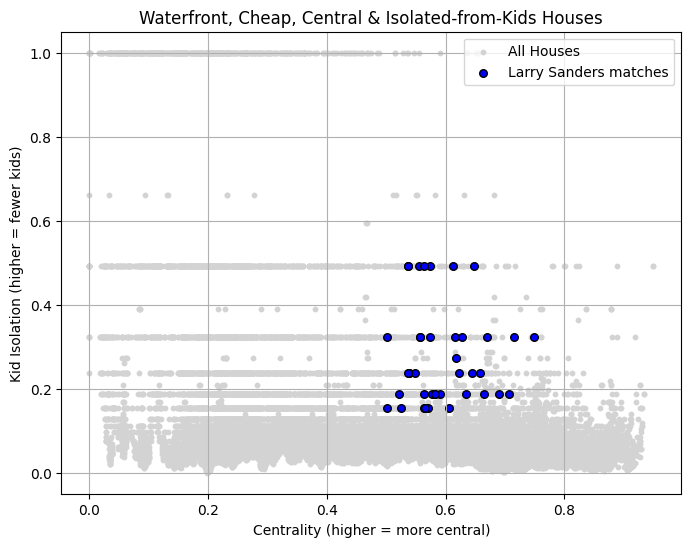

Sample houses that match Larry's criteria:


,house_id,price,waterfront,centrality_seattle,kid_density,larry_index
1150,4055701200,1960000.0,1.0,0.574511,0.677596,0.256366
1155,8069000075,790000.0,1.0,0.569650,0.846995,0.234105
1162,1247600105,5110000.0,1.0,0.554636,0.508197,0.267718
1259,7636800041,995000.0,1.0,0.563008,0.813115,0.247355
1313,7558700030,5300000.0,1.0,0.581878,0.813115,0.241573


In [20]:
df_sales_merged.head()

import matplotlib.pyplot as plt

# Apply criteria for Larry Sanders
criteria = (
    (df_sales_merged['waterfront'] == 1) &  # Waterfront
    #(df_sales_merged['price'] <= df_sales_merged['price'].quantile(0.4)) &  # Limited budget (lower 40% of prices)
    (df_sales_merged['centrality_seattle'] >= 0.5) &  # Fairly central
    (df_sales_merged['kid_density'] <= df_sales_merged['kid_density'].quantile(0.2))  # Isolated from kids
)

# Subset of houses matching criteria
larry_houses = df_sales_merged[criteria]

plt.figure(figsize=(8,6))
plt.scatter(df_sales_merged['centrality_seattle'], 1-df_sales_merged['kid_density'],
            c='lightgray', s=10, label='All Houses')
plt.scatter(larry_houses['centrality_seattle'], 1-larry_houses['kid_density'],
            c='blue', s=30, label='Larry Sanders matches', edgecolor='k')

plt.xlabel('Centrality (higher = more central)')
plt.ylabel('Kid Isolation (higher = fewer kids)')
plt.title('Waterfront, Cheap, Central & Isolated-from-Kids Houses')
plt.legend()
plt.grid(True)
plt.show()

# Print some candidates
print("Sample houses that match Larry's criteria:")
display(larry_houses[['house_id','price','waterfront','centrality_seattle','kid_density','larry_index']].head())


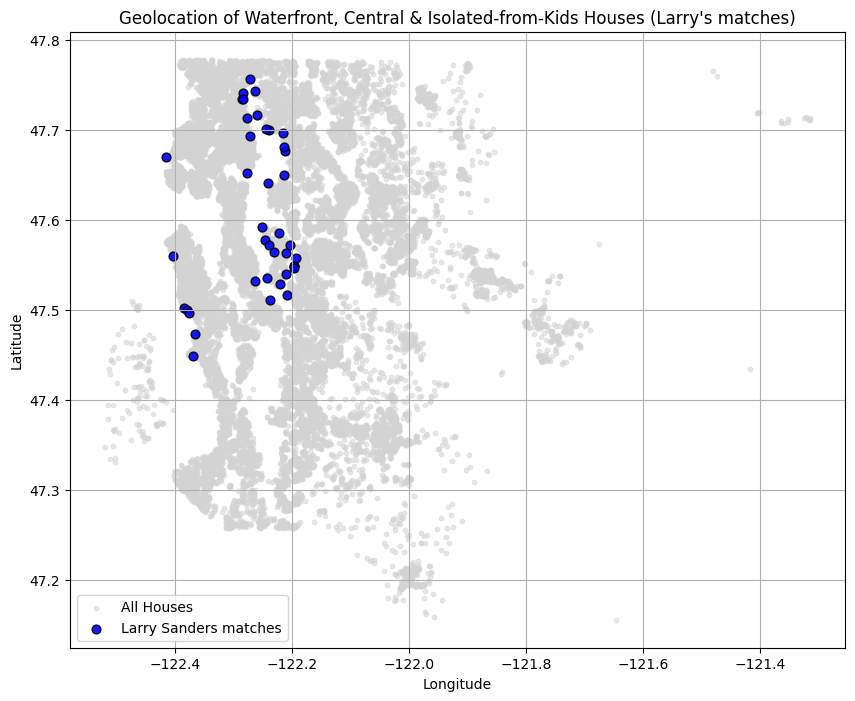

In [21]:
# Plot houses by geographic location, highlight Larry Sanders matches

plt.figure(figsize=(10,8))

# Plot all houses
plt.scatter(df_sales_merged['long'], df_sales_merged['lat'],
            c='lightgray', s=10, alpha=0.5, label='All Houses')

# Plot Larry Sanders matches
plt.scatter(larry_houses['long'], larry_houses['lat'],
            c='blue', s=40, edgecolor='k', alpha=0.9, label="Larry Sanders matches")

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Geolocation of Waterfront, Central & Isolated-from-Kids Houses (Larry's matches)")
plt.legend()
plt.grid(True)
plt.show()


In [62]:
# Plotly scatter: Waterfront + very close to central + very low kid density
try:
    import plotly.express as px

    # Define filtering criteria
    # "very close to central": select the top 10% most central (highest values)
    # "very less kids density": select the bottom 15% kid_density
    centrality_threshold = df_sales_merged['centrality_seattle'].quantile(0.05)
    kid_density_threshold = df_sales_merged['kid_density'].quantile(0.05)

    filtered_houses = df_sales_merged[
        (df_sales_merged['waterfront'] == 1) &
        (df_sales_merged['centrality_seattle'] >= centrality_threshold) &
        (df_sales_merged['kid_density'] <= kid_density_threshold)
    ]

    if not filtered_houses.empty:
        fig = px.scatter(
            filtered_houses,
            x='centrality_seattle',
            y='price',
            color='waterfront',
            size='sqft_living',
            hover_data=['house_id', 'bedrooms', 'bathrooms', 'kid_density', 'larry_index'],
            title=(
                'Waterfront, Very Central, Very Low Kid Density Houses '
                '(Hover for details!)'
            ),
            labels={'centrality_seattle': 'Centrality', 'price': 'Price ($)'}
        )
        fig.show()
        print(f"✅ Plotted {len(filtered_houses)} houses matching criteria.")
    else:
        print("⚠️ No houses match all criteria.")

except ImportError:
    print("⚠️ Plotly not installed. Install with: pip install plotly")

# Show count and table of filtered houses
house_count = len(filtered_houses)
print(f"Number of houses matching the criteria: {house_count}")


# Sort the filtered_houses DataFrame in ascending order based on 'larry_index'
if not filtered_houses.empty:
    filtered_houses_sorted = filtered_houses.sort_values(by='larry_index', ascending=True)
    display(filtered_houses_sorted[display_cols].reset_index(drop=True))
else:
    print("No houses match the given filtering criteria.")

# If you want to export the below 35 houses' details (they were displayed as filtered_houses_sorted_centrality),
# you can write them out to a CSV file as follows:

# Export the filtered and sorted houses with only the display columns
if not filtered_houses.empty:
    filtered_houses_sorted[display_cols].reset_index(drop=True).to_csv(
        "filtered_houses_35.csv", index=False
    )
    print("✅ Exported filtered houses to filtered_houses_35.csv")
else:
    print("⚠️ No filtered houses to export.")



✅ Plotted 35 houses matching criteria.
Number of houses matching the criteria: 35


,house_id,price,waterfront,centrality_seattle,kid_density,larry_index
0,1121039059,503000.0,1.0,0.271674,0.508197,0.151051
1,3225069241,2000000.0,1.0,0.310761,0.508197,0.157051
2,7558800620,600000.0,1.0,0.288636,0.508197,0.163485
3,1925069121,960000.0,1.0,0.323993,0.508197,0.164171
4,3022039071,800000.0,1.0,0.296681,0.508197,0.172925
5,8043700105,2300000.0,1.0,0.359868,0.508197,0.178772
6,9536600010,520000.0,1.0,0.340441,0.508197,0.179973
7,221029019,400000.0,1.0,0.215500,0.000000,0.187198
8,121029034,549000.0,1.0,0.218131,0.000000,0.188753
9,5119400075,950000.0,1.0,0.382947,0.508197,0.199427


✅ Exported filtered houses to filtered_houses_35.csv


In [ ]:
# Option 2: Plotly - Geographic scatter with hover tooltips
try:
    import plotly.express as px

    waterfront_houses = df_sales_merged[df_sales_merged['waterfront'] == 1]
    
    fig = px.scatter_mapbox(
        waterfront_houses,
        lat='lat',
        lon='long',
        color='price',
        size='sqft_living',
        hover_data=['house_id', 'bedrooms', 'bathrooms', 'centrality_seattle', 'kid_density'],
        color_continuous_scale='Viridis',
        size_max=15,
        zoom=9,
        title='House Locations with Price (Hover for details!)',
        mapbox_style='open-street-map'  # or 'carto-positron', 'stamen-terrain', etc.
    )
    fig.update_layout(height=600)
    fig.show()
    
except ImportError:
    print("⚠️ Plotly not installed. Install with: pip install plotly")
except Exception as e:
    print(f"⚠️ Mapbox plot requires mapbox token. Using regular scatter instead: {e}")
    # Fallback to regular scatter
    fig = px.scatter(
        df_sales_merged,
        x='long',
        y='lat',
        color='price',
        size='sqft_living',
        hover_data=['house_id', 'bedrooms', 'bathrooms', 'centrality_seattle'],
        title='House Locations (Hover for details!)'
    )
    fig.show()

# Count the number of houses matching the criteria
if not filtered_houses.empty:
    count_matches = len(filtered_houses)
    print(f"Number of houses matching the criteria: {count_matches}")
    
    # Show all details in ascending order based on centrality
    if 'centrality_seattle' in filtered_houses.columns:
        filtered_houses_sorted_centrality = filtered_houses.sort_values(by='centrality_seattle', ascending=True)
        display(filtered_houses_sorted_centrality.reset_index(drop=True))
    else:
        print("'centrality_seattle' column not found in filtered_houses DataFrame.")
else:
    print("No houses match the given filtering criteria.")


Number of houses matching the criteria: 35


,date,price,house_id,price_p_sqft_lv,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,zipcode,lat,long,sqft_living15,sqft_lot15,population_density,centrality_seattle,kid_density,larry_index,centrality_bin
0,2015-04-28,400000.0,221029019,191.387560,3.0,2.50,2090.0,32718.0,2.0,1.0,...,98070,47.3338,-122.511,1200.0,192268.0,0.151186,0.215500,0.000000,0.187198,Very Outskirts
1,2014-06-24,549000.0,121029034,269.911504,2.0,1.00,2034.0,13392.0,1.0,1.0,...,98070,47.3312,-122.503,1156.0,15961.0,0.155642,0.218131,0.000000,0.188753,Very Outskirts
2,2014-11-19,999000.0,2322029048,353.003534,3.0,2.75,2830.0,505166.0,1.0,1.0,...,98070,47.3782,-122.514,2120.0,21988.0,0.166636,0.261061,0.000000,0.223772,Outskirts
3,2014-05-22,503000.0,1121039059,175.874126,2.0,1.75,2860.0,59612.0,1.0,1.0,...,98023,47.3276,-122.389,2720.0,59612.0,0.290365,0.271674,0.508197,0.151051,Outskirts
4,2014-08-22,600000.0,7558800620,387.096774,2.0,1.75,1550.0,7764.0,1.0,1.0,...,98070,47.3580,-122.446,1690.0,11620.0,0.257329,0.288636,0.508197,0.163485,Outskirts
5,2014-05-30,800000.0,3022039071,462.427746,2.0,2.25,1730.0,31491.0,2.0,1.0,...,98070,47.3730,-122.464,1400.0,12410.0,0.207463,0.296681,0.508197,0.172925,Outskirts
6,2015-04-20,480000.0,1922039062,476.190476,2.0,1.50,1008.0,26487.0,1.0,1.0,...,98070,47.3853,-122.479,1132.0,24079.0,0.199350,0.300841,0.000000,0.250836,Outskirts
7,2015-04-22,2000000.0,3225069241,573.065903,3.0,2.50,3490.0,21064.0,1.0,1.0,...,98074,47.6092,-122.073,1780.0,15244.0,0.470532,0.310761,0.508197,0.157051,Outskirts
8,2014-06-24,3080000.0,3225069065,676.923077,4.0,5.00,4550.0,18641.0,1.0,1.0,...,98074,47.6053,-122.077,4550.0,19508.0,0.470688,0.317350,0.000000,0.215783,Outskirts
9,2014-09-17,340000.0,222029026,320.754717,2.0,0.75,1060.0,48292.0,1.0,1.0,...,98070,47.4285,-122.511,750.0,80201.0,0.188467,0.322250,0.000000,0.271148,Outskirts


Exported filtered house details to filtered_houses_35.csv


In [33]:
# Option 4: Bar chart with hover tooltips (Plotly)
try:
    import plotly.express as px
    
    # Using the centrality_price data from earlier
    centrality_price = df_sales_merged.groupby('centrality_bin')['price'].mean().reset_index()
    
    fig = px.bar(
        centrality_price,
        x='centrality_bin',
        y='price',
        title='Average House Price by Centrality (Hover for exact values!)',
        labels={'centrality_bin': 'Central Location', 'price': 'Average Price ($)'},
        text='price'  # Shows values on bars
    )
    fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside')
    fig.update_layout(xaxis={'categoryorder': 'array', 
                              'categoryarray': ['Very Outskirts', 'Outskirts', 'Mid', 'Central', 'Very Central']})
    fig.show()
    
except ImportError:
    print("⚠️ Plotly not installed. Install with: pip install plotly")


In [65]:
import plotly.express as px

if not filtered_houses.empty and 'larry_index' in filtered_houses.columns:
    # Sort by larry_index descending (most relevant first)
    relevant_houses = filtered_houses.sort_values(by='larry_index', ascending=False).reset_index(drop=True)
    
    # Plot top 10 most relevant houses (or all, if fewer than 10)
    top_n = min(10, len(relevant_houses))
    fig = px.bar(
        relevant_houses.iloc[:top_n],
        x='house_id',
        y='larry_index',
        hover_data=['price', 'centrality_seattle', 'bedrooms', 'bathrooms','kid_density'],
        title=f"Top {top_n} Most Relevant Houses Matching Criteria (by larry_index)",
        labels={'house_id': 'House ID', 'larry_index': 'Relevance (larry_index)'},
        text='larry_index'
    )
    fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
    fig.update_layout(
        xaxis_tickangle=-30,
        yaxis=dict(range=[0, 1]),
        showlegend=False
    )
    fig.show()
else:
    print("Cannot plot relevance by larry_index; no matching filtered_houses or column missing.")

    # Add 'kid_density' to hover_data for tooltip in bar plot
    import plotly.express as px

    if not filtered_houses.empty and 'larry_index' in filtered_houses.columns:
        # Sort by larry_index descending (most relevant first)
        relevant_houses = filtered_houses.sort_values(by='larry_index', ascending=False).reset_index(drop=True)

        # Plot top 10 most relevant houses (or all, if fewer than 10)
        top_n = min(10, len(relevant_houses))
        fig = px.bar(
            relevant_houses.iloc[:top_n],
            x='house_id',
            y='larry_index',
            hover_data=['price', 'centrality_seattle', 'bedrooms', 'bathrooms', 'kid_density'],
            title=f"Top {top_n} Most Relevant Houses Matching Criteria (by larry_index)",
            labels={'house_id': 'House ID', 'larry_index': 'Relevance (larry_index)'},
            text='larry_index'
        )
        fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
        fig.update_layout(
            xaxis_tickangle=-30,
            yaxis=dict(range=[0, 1]),
            showlegend=False
        )
        fig.show()
    else:
        print("Cannot plot relevance by larry_index; no matching filtered_houses or column missing.")
